In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Lambda, Reshape, Conv2DTranspose, Layer
from tensorflow.keras import backend as K
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import h5py
import cv2
import imageio
import os

In [2]:
latent_dim = 5
input_shape = (64, 64, 4)

input_img = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

conv_shape =  K.int_shape(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

z_mu = Dense(latent_dim, name='latent_mu')(x)   
z_sigma = Dense(latent_dim, name='latent_sigma')(x)  

def sample_z(args):
    z_mu, z_sigma = args
    eps = tf.keras.backend.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
    return z_mu + K.exp(z_sigma / 2) * eps


z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')

In [3]:
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

x = Flatten()(decoder_input)
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(x)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2DTranspose(1, 1, padding='same', activation='sigmoid', name = 'decoder_output')(x)


decoder = Model(decoder_input, x, name='decoder')
# decoder.summary()

z_decoded = decoder(z)

In [4]:
vae = Model(input_img, z_decoded, name='vae')

# Compile VAE
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64, 64, 4)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   1184        encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 64)   36928       conv2d_1[0][0]                   
________________________________________________________________________________________________

### Loading data

In [5]:
def read_images(files):
    if type(files) == list:
        temp = []
        for i in files:
            img = tf.keras.preprocessing.image.load_img(i)
            img = tf.keras.preprocessing.image.img_to_array(img)
            img = tf.image.resize(img, (64, 64))
            img = tf.image.rgb_to_grayscale(img)
            img /= 255.0
            temp.append(img)
            
        temp = np.array(temp)
        temp = np.concatenate(temp, axis = -1)
        temp = np.reshape(temp, (64, 64, 4))
        return temp
    
    else:
        img = tf.keras.preprocessing.image.load_img(files)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = tf.image.resize(img, (64, 64))
        img = tf.image.rgb_to_grayscale(img)
        img /= 255.0

        return img

In [6]:
   
def data_preprocessing(directory_path):
    files_dict = dict()
    
    for img in os.listdir(directory_path):
        
        if img.split('_')[2] + '_' + img.split('_')[3] not in files_dict.keys():
            files_dict[img.split('_')[2] + '_' + img.split('_')[3]] = [img]
            
        else:
            files_dict[img.split('_')[2] + '_' + img.split('_')[3]].append(img)

    groups = []

    for keys, values in files_dict.items():
        groups.append(values)

    del files_dict
    
    labels = []
    
    for count, i in tqdm(enumerate(groups)):
        for idx in range(len(i)):
            if len(i[idx].split('_')[4].split('.')[0]) > 1:
                labels.append(os.path.join(directory_path, groups[count][idx]))
                groups[count].remove(groups[count][idx])
                if len(groups[count]) >= 4:
                    groups[count] = groups[count][:4]
                    groups[count] = [os.path.join(directory_path, i) for i in groups[count]]
                break
    
    X = np.array(list(map(read_images, groups)))
    y = np.array(list(map(read_images, labels)))
    
    return X, y

def big_set():
    ## Reading
    ntrain = 4000
    Train_hdf5_file ='../Data/X_y_temp_4000.hdf5'
    with h5py.File(Train_hdf5_file, 'r') as f:
        print(len(f['x_train']))
        y_train = f['x_train'][:ntrain]
        x_train = f['y_train'][:ntrain]
        y_test = f['x_test'][:int(ntrain/3)]
        x_test = f['y_test'][:int(ntrain/3)]

        x_train = np.swapaxes(x_train, 1, -1)
        x_test = np.swapaxes(x_test, 1, -1)

        return x_train, y_train, x_test, y_test

In [7]:
X, y = data_preprocessing('..\\..\\data\\data_256\\data')

1170it [00:00, 154294.47it/s]


In [8]:
x_train, x_test, y_train, y_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):], y[:int(len(X)*0.8)], y[int(len(X)*0.8):]
del X, y
plot_example = x_test[0:1]

In [9]:
x_train.shape

(936, 64, 64, 4)

In [10]:
y_test.shape

(234, 64, 64, 1)

### Training

In [11]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16)

In [12]:
val_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(16)

In [13]:
optimizer = tf.keras.optimizers.Adam()

In [14]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [15]:
def save_img(epoch):
    image = vae(plot_example).numpy().reshape((64, 64)) * 255.0
    if os.path.exists('progress'):
        cv2.imwrite(f'progress/{epoch}.png', image)
    else:
        os.mkdir('progress')
        cv2.imwrite(f'progress/{epoch}.png', image)

In [16]:
def vae_loss(y_true, y_pred, model):

    # Reconstruction loss (as we used sigmoid activation we can use binarycrossentropy)
    try:
        assert(y_true.shape == y_pred.shape)
        y_true = K.flatten(y_true)
        y_pred = K.flatten(y_pred)
        recon_loss = tf.keras.metrics.binary_crossentropy(y_true, y_pred)

        # KL divergence
        z_mu = vae.get_layer('latent_mu').weights[0]
        z_sigma = vae.get_layer('latent_sigma').weights[0]

        kl_loss = -5e-4 * tf.math.reduce_mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)

        return (recon_loss + kl_loss) / 2
    
    except:
        print(y_true.shape)
        print(y_pred.shape)

In [17]:
def apply_gradient(optimizer, model, x, y):
    with tf.GradientTape() as tape:
        logits = vae(x)
        loss_value = vae_loss(y_true=y, y_pred=logits, model = vae)
        
    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    loss_value = np.mean(loss_value)
    return logits, loss_value

In [18]:
def train_data_for_one_epoch(data, epoch):
    losses = []
    pbar = tqdm(total=len(list(enumerate(data))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
    for step, (x_batch_train, y_batch_train) in enumerate(data):
        logits, loss_value = apply_gradient(optimizer, vae, x_batch_train, y_batch_train)
      
        losses.append(loss_value)
        
        train_acc_metric(y_batch_train, logits)
        
        pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
        pbar.update()
    
    save_img(epoch)
    return losses

In [19]:
def perform_validation(test):
    losses = []
    for x_val, y_val in test:
        val_logits = vae(x_val)
        val_loss = vae_loss(y_true=y_val, y_pred=val_logits, model = vae)
        losses.append(np.mean(val_loss))
        val_acc_metric(y_val, val_logits)
    return losses

In [27]:
acc = tf.keras.metrics.SparseCategoricalAccuracy()
acc.update_state(y_train, vae.predict(x_train))
acc.result().numpy()

0.27710065

In [28]:
losses_training = []
losses_validation = []

accuracy_training = []
accuracy_validation = []

In [39]:
for epoch in range(50):
    print('Start of epoch %d' % (epoch,))
  
    losses_train = train_data_for_one_epoch(train_data, epoch)
    train_acc = train_acc_metric.result()

    losses_val = perform_validation(val_data)
    val_acc = val_acc_metric.result()

    losses_train_mean = np.mean(losses_train)
    losses_val_mean = np.mean(losses_val)
        
    losses_training.append(losses_train_mean)
    losses_validation.append(losses_val_mean)
    
    accuracy_training.append(train_acc)
    accuracy_validation.append(val_acc)
    
    print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f Train Accuracy: %.4f Validation Accuracy %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc)))
  
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()

Start of epoch 0


Training loss for step 58: 0.0249:  98%|█████████████████████████████████████████████████████████████████████▊ | 58/59 


 Epoch 0: Train loss: 0.0226  Validation Loss: 0.1165 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 1


Training loss for step 58: 0.0228: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 1: Train loss: 0.0225  Validation Loss: 0.1118 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 2


Training loss for step 58: 0.0222: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 2: Train loss: 0.0222  Validation Loss: 0.1110 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 3


Training loss for step 58: 0.0227: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 3: Train loss: 0.0233  Validation Loss: 0.0825 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 4


Training loss for step 58: 0.0244: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 4: Train loss: 0.0273  Validation Loss: 0.0790 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 5


Training loss for step 58: 0.0247: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 5: Train loss: 0.0419  Validation Loss: 0.0826 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 6


Training loss for step 58: 0.0249: 100%|███████████████████████████████████████████████████████████████████████| 59/59 
Training loss for step 58: 0.0253: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 6: Train loss: 0.0403  Validation Loss: 0.0813 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 7


Training loss for step 58: 0.0251: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 7: Train loss: 0.0338  Validation Loss: 0.0753 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 8


Training loss for step 58: 0.0226: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 8: Train loss: 0.0257  Validation Loss: 0.0747 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 9


Training loss for step 58: 0.0240: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 9: Train loss: 0.0264  Validation Loss: 0.0758 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 10


Training loss for step 58: 0.0225: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 10: Train loss: 0.0258  Validation Loss: 0.0748 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 11


Training loss for step 58: 0.0227: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 11: Train loss: 0.0259  Validation Loss: 0.0750 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 12


Training loss for step 58: 0.0208: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 12: Train loss: 0.0223  Validation Loss: 0.0750 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 13


Training loss for step 58: 0.0206: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 13: Train loss: 0.0230  Validation Loss: 0.0735 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 14


Training loss for step 58: 0.0198: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 14: Train loss: 0.0212  Validation Loss: 0.0737 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 15


Training loss for step 58: 0.0264: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 15: Train loss: 0.0209  Validation Loss: 0.0859 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 16


Training loss for step 58: 0.0205: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 16: Train loss: 0.0211  Validation Loss: 0.0799 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 17


Training loss for step 58: 0.0219: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 17: Train loss: 0.0294  Validation Loss: 0.0743 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 18


Training loss for step 58: 0.0205: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 18: Train loss: 0.0225  Validation Loss: 0.0773 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 19


Training loss for step 58: 0.0218: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 19: Train loss: 0.0211  Validation Loss: 0.0822 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 20


Training loss for step 58: 0.0217: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 20: Train loss: 0.0206  Validation Loss: 0.0760 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 21


Training loss for step 58: 0.0213: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 21: Train loss: 0.0209  Validation Loss: 0.0740 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 22


Training loss for step 58: 0.0236: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 22: Train loss: 0.0247  Validation Loss: 0.0862 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 23


Training loss for step 58: 0.0226: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 23: Train loss: 0.0231  Validation Loss: 0.0800 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 24


Training loss for step 58: 0.0202: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 24: Train loss: 0.0234  Validation Loss: 0.0743 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 25


Training loss for step 58: 0.0199: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 25: Train loss: 0.0206  Validation Loss: 0.0778 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 26


Training loss for step 58: 0.0208: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 26: Train loss: 0.0207  Validation Loss: 0.0719 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 27


Training loss for step 58: 0.0201: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 27: Train loss: 0.0199  Validation Loss: 0.0762 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 28


Training loss for step 58: 0.0207: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 28: Train loss: 0.0210  Validation Loss: 0.0714 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 29


Training loss for step 58: 0.0195: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 29: Train loss: 0.0196  Validation Loss: 0.0754 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 30


Training loss for step 58: 0.0312: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 30: Train loss: 0.0217  Validation Loss: 0.0885 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 31


Training loss for step 58: 0.0215: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 31: Train loss: 0.0208  Validation Loss: 0.0812 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 32


Training loss for step 58: 0.0219: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 32: Train loss: 0.0271  Validation Loss: 0.0803 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 33


Training loss for step 58: 0.0210: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 33: Train loss: 0.0220  Validation Loss: 0.0811 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 34


Training loss for step 58: 0.0196: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 34: Train loss: 0.0252  Validation Loss: 0.0693 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 35


Training loss for step 58: 0.0222: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 35: Train loss: 0.0233  Validation Loss: 0.0826 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 36


Training loss for step 58: 0.0183: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 36: Train loss: 0.0205  Validation Loss: 0.0700 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 37


Training loss for step 58: 0.0191: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 37: Train loss: 0.0210  Validation Loss: 0.0764 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 38


Training loss for step 58: 0.0195: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 38: Train loss: 0.0194  Validation Loss: 0.0691 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 39


Training loss for step 58: 0.0178: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 39: Train loss: 0.0191  Validation Loss: 0.0704 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 40


Training loss for step 58: 0.0192: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 40: Train loss: 0.0201  Validation Loss: 0.0798 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 41


Training loss for step 58: 0.0206: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 41: Train loss: 0.0186  Validation Loss: 0.0827 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 42


Training loss for step 58: 0.0215: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 42: Train loss: 0.0195  Validation Loss: 0.0796 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 43


Training loss for step 58: 0.0187: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 43: Train loss: 0.0214  Validation Loss: 0.0763 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 44


Training loss for step 58: 0.0229: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 44: Train loss: 0.0219  Validation Loss: 0.0951 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 45


Training loss for step 58: 0.0194: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 45: Train loss: 0.0215  Validation Loss: 0.0804 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 46


Training loss for step 58: 0.0187: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 46: Train loss: 0.0197  Validation Loss: 0.0885 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 47


Training loss for step 58: 0.0179: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 47: Train loss: 0.0192  Validation Loss: 0.0820 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 48


Training loss for step 58: 0.0196: 100%|███████████████████████████████████████████████████████████████████████| 59/59 



 Epoch 48: Train loss: 0.0192  Validation Loss: 0.0944 Train Accuracy: 0.2771 Validation Accuracy 0.2725
Start of epoch 49


Training loss for step 58: 0.0192:  98%|█████████████████████████████████████████████████████████████████████▊ | 58/59 


 Epoch 49: Train loss: 0.0200  Validation Loss: 0.0899 Train Accuracy: 0.2771 Validation Accuracy 0.2725


Training loss for step 58: 0.0192: 100%|███████████████████████████████████████████████████████████████████████| 59/59 


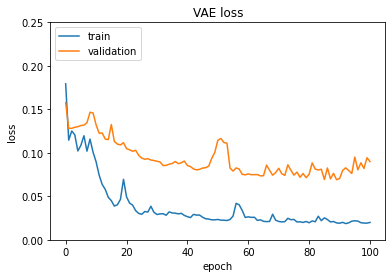

In [40]:
from matplotlib import pyplot as plt

plt.plot(losses_training)
plt.plot(losses_validation)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 0.25])
plt.title('VAE loss')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

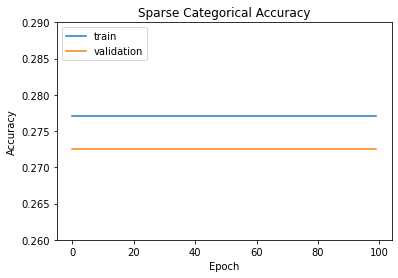

In [41]:
import matplotlib.pyplot as plt

plt.plot(accuracy_training)
plt.plot(accuracy_validation)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.260, 0.290])
plt.title('Sparse Categorical Accuracy')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

In [42]:
accuracy = [0 for i in range(100)]

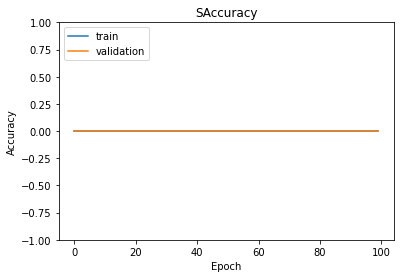

In [44]:
import matplotlib.pyplot as plt

plt.plot(accuracy)
plt.plot(accuracy, )
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([-1, 1])
plt.title('SAccuracy')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

In [42]:
png_dir = 'progress'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave('movie.gif', images, fps = 10)

Training loss for step 58: 0.0251: 100%|███████████████████████████████████████████████████████████████████████| 59/59 

In [43]:
vae.save('models/vae_main.h5')

Training loss for step 58: 0.0251: 100%|███████████████████████████████████████████████████████████████████████| 59/59 
